<a href="https://colab.research.google.com/github/benedettoscala/ifttt-code-generator/blob/main/bart_nl2ifttt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup
In this section, we install the necessary dependencies for the notebook. The libraries `evaluate` and `rouge_score` are installed to facilitate text evaluation, particularly for computing ROUGE scores, which are commonly used for assessing the quality of text generation models.



In [19]:
!pip install evaluate
!pip install rouge_score

Defaulting to user installation because normal site-packages is not writeable
  Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable



### Repository Cloning and Setup
We clone the `ifttt-code-generator` repository from GitHub, which contains the required code for this project. After cloning, we navigate into the repository directory and pull the latest changes to ensure we have the most up-to-date version.

In [ ]:
!git clone https://github.com/benedettoscala/ifttt-code-generator
%cd ifttt-code-generator/
!git pull

Cloning into 'ifttt-code-generator'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 149 (delta 86), reused 25 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (149/149), 14.68 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/ifttt-code-generator
Already up to date.


### Dataset Processing and Tokenization
This section of the notebook performs dataset loading, cleaning, and tokenization using the `facebook/bart-large` tokenizer.

- First, the necessary libraries (`pandas`, `numpy`, `matplotlib.pyplot`, and `transformers`) are imported.
- The `facebook/bart-large` tokenizer is loaded, and if no padding token is defined, it is set to the EOS token.
- A dataset is loaded from a CSV file (`datasets/cleaned_and_combined.csv`), and data cleaning is applied by removing missing values and duplicate entries in the relevant columns.
- Each sample in the dataset is tokenized separately for the description, code, and the combined text using a separator (`\n###\n`).
- Token length statistics (min, max, mean, and median) are computed for the description, code, and full text.
- Finally, a histogram is plotted to visualize the distribution of token lengths in the dataset, with a reference line at 256 tokens to help assess token length constraints.


Token indices sequence length is longer than the specified maximum sequence length for this model (3187 > 1024). Running this sequence through the model will result in indexing errors


Statistiche per la descrizione:
  Min: 23
  Max: 42
  Media: 28.49163879598662
  Mediana: 28.0

Statistiche per il codice:
  Min: 11
  Max: 21027
  Media: 317.3478260869565
  Mediana: 76.0

Statistiche per il testo completo (descrizione + codice):
  Min: 40
  Max: 21058
  Media: 346.83946488294316
  Mediana: 108.0



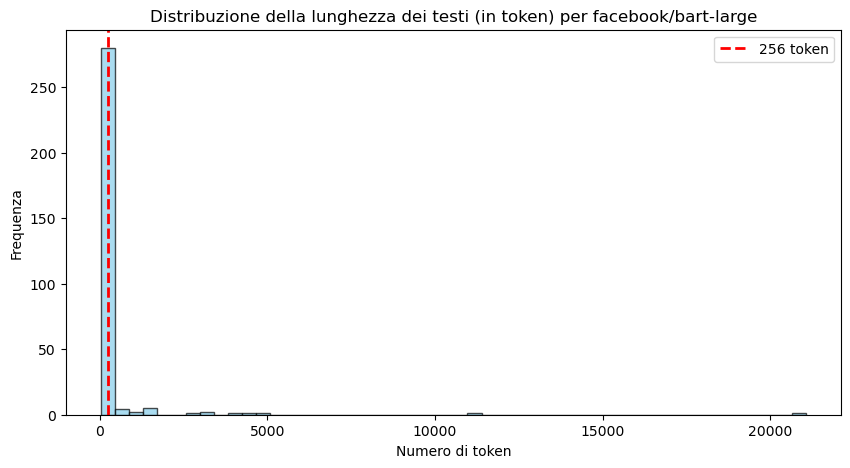

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Imposta il checkpoint del modello (BART-large)
model_checkpoint = "facebook/bart-large"

# Carica il tokenizer per facebook/bart-large
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Se il tokenizer non ha un token di padding definito, impostalo uguale al token EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Carica il dataset
csv_path = "datasets/new_dataset.csv"
df = pd.read_csv(csv_path)

# Rimuovi righe con valori mancanti e duplicati nelle colonne di interesse
df.dropna(subset=["permission_df", "filter_code"], inplace=True)
df.drop_duplicates(subset=["permission_df", "filter_code"], inplace=True)

# Definisci un separatore per unire descrizione e codice
separator = "\n###\n"

# Liste per salvare le lunghezze in token
description_lengths = []
code_lengths = []
combined_lengths = []

# Itera su ogni esempio nel dataset
for _, row in df.iterrows():
    description = row["permission_df"]
    code = row["filter_code"]

    # Tokenizza la descrizione senza troncamento
    desc_tokens = tokenizer.encode(description, truncation=False)
    # Tokenizza il codice senza troncamento
    code_tokens = tokenizer.encode(code, truncation=False)
    # Tokenizza la concatenazione: descrizione + separatore + codice
    combined_text = description + separator + code
    combined_tokens = tokenizer.encode(combined_text, truncation=False)

    # Salva le lunghezze
    description_lengths.append(len(desc_tokens))
    code_lengths.append(len(code_tokens))
    combined_lengths.append(len(combined_tokens))

# Funzione per stampare statistiche (min, max, media, mediana)
def print_stats(name, lengths):
    print(f"Statistiche per {name}:")
    print("  Min:", np.min(lengths))
    print("  Max:", np.max(lengths))
    print("  Media:", np.mean(lengths))
    print("  Mediana:", np.median(lengths))
    print()

print_stats("la descrizione", description_lengths)
print_stats("il codice", code_lengths)
print_stats("il testo completo (descrizione + codice)", combined_lengths)

# Visualizza la distribuzione della lunghezza in token del testo completo
plt.figure(figsize=(10, 5))
plt.hist(combined_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(256, color='red', linestyle='dashed', linewidth=2, label="256 token")
plt.title("Distribuzione della lunghezza dei testi (in token) per facebook/bart-large")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

### Import Libraries

In [2]:
from transformers import AutoTokenizer, BartForConditionalGeneration
from datasets import load_dataset,load_from_disk
import torch
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize

### Dataset Loading and Splitting
This section of the notebook loads and processes the dataset for training and evaluation.

- The dataset is loaded from a CSV file using `pandas`.
- Data cleaning is applied by removing missing values and duplicate entries in the `permission_df` and `filter_code` columns.
- The dataset is then split into training (80%) and testing (20%) subsets using `train_test_split`, ensuring reproducibility with a fixed random seed (`random_state=42`).
- The `pandas` DataFrames are converted into Hugging Face `Dataset` objects for better compatibility with NLP models.
- Finally, the dataset is structured into a `DatasetDict`, which organizes the training and testing sets for further processing.

The number of examples in the training and test sets is printed at the end to confirm the split.


In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict

# Caricamento del dataset
csv_path = "datasets/new_dataset.csv"
df = pd.read_csv(csv_path)

#droppa i duplicati e i valori nulli se ci sono
df.dropna(subset=["permission_df", "filter_code"], inplace=True)
#df.drop_duplicates(subset=["permission_df", "filter_code"], inplace=True)

# Suddivisione in train e test set (80%-20%)
train_df, test_df = train_test_split(df, test_size=0.356, random_state=42)

# Convertiamo i DataFrame in Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Stampa delle dimensioni dei set di training e test
print("Train set size:", len(dataset["train"]))
print("Test set size:", len(dataset["test"]))

Train set size: 393
Test set size: 218


In [4]:
model_checkpoint = "facebook/bart-large"

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Model Tokenization and Preprocessing
In this section, we define the tokenizer and preprocess the dataset for training.

- The `facebook/bart-large` tokenizer is loaded using `AutoTokenizer.from_pretrained`.
- We define the maximum input length (128 tokens) and target length (200 tokens) to ensure that text sequences fit within the model's constraints.
- A prefix (`ifttt_prompt: `) is added to each description to provide context for the model.
- The `preprocess_function` tokenizes the descriptions (`permission_df`) and corresponding code snippets (`filter_code`), ensuring that they respect the defined token limits and truncation settings.
- The labels (target sequences) are tokenized separately, and their token IDs are stored within the model input structure.
- Finally, the preprocessing function is applied to the dataset using `.map()` to tokenize all data efficiently.

The progress bars at the bottom confirm that the dataset has been successfully tokenized.


In [6]:
max_input_length = 128
max_target_length = 256
prefix1 = "ifttt_prompt: "

def preprocess_function(examples):
    model_inputs = tokenizer([prefix1 + prompt for prompt in examples['permission_df']],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples['filter_code'], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/393 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

### Evaluation Metrics Setup
In this section, we load three commonly used evaluation metrics for text generation tasks using the `evaluate` library:

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** Measures overlap between generated text and reference text based on n-grams and longest common subsequence. It is widely used for summarization tasks.
- **BLEU (Bilingual Evaluation Understudy):** Computes precision-based similarity by comparing generated text with reference translations. It is commonly used in machine translation.
- **METEOR (Metric for Evaluation of Translation with Explicit ORdering):** Improves upon BLEU by considering synonym matching, stemming, and word order to provide a more nuanced evaluation.

These metrics will be used to assess the quality of model-generated text by comparing it with ground-truth references.


In [8]:
import evaluate

rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Model Initialization
In this section, we load and configure the model for sequence-to-sequence learning.

- The `facebook/bart-large` model is loaded using `AutoModelForSeq2SeqLM.from_pretrained()`, which retrieves a pre-trained sequence-to-sequence model.
- The generation parameters are set:
  - `max_new_tokens = 200`: The model can generate up to 128 tokens per output.
  - `min_new_tokens = 5`: The model must generate at least 5 tokens.
- These settings are applied both through `generation_config` and `config` to ensure consistency.

Once the model is loaded, we can use it for text generation tasks.



In [9]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [10]:
model.generation_config.max_new_tokens = 256
model.generation_config.min_new_tokens = 5
model.config.max_new_tokens = 256
model.config.min_new_tokens = 5

In [11]:
print(model.config)

BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-large",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

In [12]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "max_new_tokens": 256,
  "min_new_tokens": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}




### Data Collator
This section prepares the data for training by using a data collator.

- `DataCollatorForSeq2Seq` is initialized with the tokenizer and model to dynamically pad inputs to the longest sequence in a batch, improving computational efficiency.
- Unnecessary columns from the tokenized dataset are removed to ensure compatibility with the model.
- A sample batch of two training examples is processed through the data collator, demonstrating the transformation into tensor format.

The data collator ensures that input sequences are properly formatted and padded for efficient batch processing.


In [13]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [14]:
tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [15]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[    0,  1594,  5967,    90,  1215, 12501,  3320,    35,   114,   188,
          3545,    30,    10,  2167,  3018,    36, 45043,  1215, 11131,    35,
           599,    43,   172, 10683,    10, 12059,    31,     5,    38, 11615,
         14543,  1553,    36, 10845,  1215, 11131,    35,  1491, 14868,    43,
             2],
        [    0,  1594,  5967,    90,  1215, 12501,  3320,    35,   114,  5053,
            92,  1591,    36, 45043,  1215, 11131,    35,  6068, 36859,    43,
           172,  9359,  3581,    36, 10845,  1215, 11131,    35,  6894,  1309,
            43,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tens

#### Post Processing for ROUGE computation

In [16]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [17]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Seq2Seq Model Training and Evaluation
This section fine-tunes a **sequence-to-sequence (Seq2Seq)** model and evaluates its performance using **ROUGE, BLEU, and METEOR** scores.

#### **Evaluation Metrics**
- **ROUGE Score:** Measures n-gram and sequence overlap between predictions and reference texts.
- **BLEU Score:** Evaluates word sequence precision compared to ground-truth references.
- **METEOR Score:** Accounts for stemming, synonyms, and word order for a more nuanced evaluation.

#### **Custom Metric Computation (`compute_metrics`)**
- Processes model predictions and ground-truth labels:
  - Handles different data types (tuples, tensors) and converts them to NumPy arrays.
  - Replaces `-100` values in labels with the tokenizer’s **pad token ID** (used for ignored tokens in training).
  - Decodes tokenized sequences back into human-readable text.
  - Cleans text using `postprocess_text()` to ensure consistency in evaluation.
- Computes **ROUGE, BLEU, and METEOR** scores.
- Normalizes values and formats them into a structured dictionary.

#### **Training Arguments (`Seq2SeqTrainingArguments`)**
- **Output Directory:**  
  - Saves training outputs in `"/content/drive/Shareddrives/NLPMODELS/nl2sql_bart_final"`.
- **Training and Evaluation Settings:**
  - **Epoch-based evaluation (`evaluation_strategy="epoch"`)**: The model is evaluated at the end of each epoch.
  - **Epoch-based logging (`logging_strategy="epoch"`)**: Logs training progress after each epoch.
  - **Batch Size:**  
    - `per_device_train_batch_size=8` → Training batch size per device.  
    - `per_device_eval_batch_size=8` → Evaluation batch size per device.
  - **Training Duration:**  
    - `num_train_epochs=20` → The model is fine-tuned for 20 epochs.
  - **Precision Optimization:**  
    - `fp16=torch.cuda.is_available()` → Enables **half-precision (FP16)** training on GPUs for efficiency.
  - **Inference Settings:**  
    - `predict_with_generate=True` → Ensures predictions are generated rather than just outputting logits.
  - **Data Cleaning:**  
    - `remove_unused_columns=True` → Removes irrelevant columns for training.

#### **Trainer Initialization (`Seq2SeqTrainer`)**
- Manages the training process:
  - Uses `train_dataset` and `eval_dataset` from the tokenized dataset.
  - Applies `data_collator` for dynamic batch padding.
  - Uses the `compute_metrics` function for automatic performance evaluation.

#### **Training Execution**
- The training process is started using `trainer.train()`.

This setup **automates fine-tuning, evaluation, and model checkpointing**, ensuring efficient training and evaluation for text generation.


In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np
import torch

# Carica le metriche
rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

num_train_epochs = 20

# Funzione per la generazione e la valutazione delle metriche
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Se predictions è un tuple, prendi il primo elemento
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Converte in numpy array se necessario
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Se predictions è una lista nidificata, appiattiscila
    predictions = np.array(predictions)

    # Rimpiazza -100 nei labels con tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decodifica delle predizioni e delle etichette
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rimozione di spazi inutili
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Calcolo delle metriche
    rouge_results = rouge_score.compute(predictions=decoded_preds, references=decoded_labels)
    bleu_results = bleu_score.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_results = meteor_score.compute(predictions=decoded_preds, references=decoded_labels)

    # Normalizza i valori delle metriche
    rouge_results = {k: round(v * 100, 4) for k, v in rouge_results.items()}
    bleu_results = round(bleu_results["bleu"] * 100, 2)
    meteor_results = round(meteor_results["meteor"] * 100, 2)

    return {
        **rouge_results,
        "bleu": bleu_results,
        "meteor": meteor_results
    }

output_dir_model = "results/best_model_bart"

# Definizione degli argomenti di training
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir_model,
    #evaluation_strategy="epoch",  # Valutazione dopo ogni epoca
    logging_strategy="epoch",
    #save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    save_total_limit=5,
    fp16=torch.cuda.is_available(),  # Usa FP16 se disponibile
    report_to="none",  # Evita di inviare log a sistemi di tracking
    predict_with_generate=True,  # Usa generate() durante l'inferenza
    remove_unused_columns=True
)

# Creazione del Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Avvio del training
trainer.train()

trainer.save_model(output_dir_model)



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DaisLabTBB\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\DaisLabTBB\AppData\Local\Temp\ipykernel_14568\619561072.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
50,3.377700
100,1.657900
150,1.246900
200,1.001700
250,0.805300
300,0.703200
350,0.595900
400,0.521400
450,0.454500
500,0.408200


C:\Users\DaisLabTBB\AppData\Roaming\Python\Python310\site-packages\transformers\modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [ ]:
# prompt: evaluate the model on the test set

# Evaluate the model on the test set
results = trainer.evaluate()
results


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 1.6603342294692993,
 'eval_rouge1': 50.0823,
 'eval_rouge2': 34.8817,
 'eval_rougeL': 47.5114,
 'eval_rougeLsum': 47.6926,
 'eval_bleu': 37.06,
 'eval_meteor': 48.28,
 'eval_runtime': 19.4414,
 'eval_samples_per_second': 1.749,
 'eval_steps_per_second': 0.257,
 'epoch': 20.0}

### Model Inference with Text-to-Text Pipeline
In this section, we load the trained model and use it for text generation.

#### **Model Loading**
- The trained model is loaded from the specified checkpoint directory (`nl2sql_epoch30`).
- The `pipeline` function from `transformers` is used to create a text-to-text generation pipeline.
- Both the model and tokenizer are loaded from the same checkpoint to ensure compatibility.

#### **Generating Predictions**
- A sample prompt is provided to the model:  
  `"ifttt prompt: Create an applet that saves new photos from my phone to a Google Drive folder automatically"`
- The model generates a text-based response using `pipeline("text2text-generation")`.

#### **Usage**
- This pipeline allows the model to generate structured text based on natural language prompts.
- It can be used to create IFTTT-like (If This Then That) automation rules based on textual descriptions.

This setup enables efficient inference, allowing the model to process user inputs and generate corresponding automation rules.


In [ ]:

from transformers import pipeline


model_path = "/content/drive/Shareddrives/NLPMODELS/nl2sql_bart_final/checkpoint-340"

# Load the pipeline
generator = pipeline("text2text-generation", model=model_path, tokenizer=model_path)

# Example usage
prompt = "ifttt prompt: Create an applet that Save new photos from my phone to a Google Drive folder automatically"
result = generator(prompt)

result

Device set to use cuda:0
Both `max_new_tokens` (=200) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'if (Trigger.newPhotoFromMyPhone.Text.indexOf("Photo") < 0) {    GoogleDrive.createPhotoFolder.skip("Not related to me") }'}]

In [ ]:
%ls

drive/  ifttt-code-generator/  sample_data/


In [ ]:
import pandas as pd
from transformers import pipeline
from sklearn.model_selection import train_test_split

# Load the trained model and tokenizer
model_path = "/content/drive/Shareddrives/NLPMODELS/nl2sql_bart_final/checkpoint-340"
generator = pipeline("text2text-generation", model=model_path, tokenizer=model_path)

# Load the dataset and split it with random state 42
df = pd.read_csv("ifttt-code-generator/datasets/cleaned_and_combined.csv")

#drop duplicates
df.dropna(subset=["permission_df", "filter_code"], inplace=True)
df.drop_duplicates(subset=["permission_df", "filter_code"], inplace=True)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare lists to store results
prompts = []
generated_codes = []
actual_codes = []

# Iterate over the test set prompts
for index, row in test_df.iterrows():
    prompt = row["permission_df"]
    actual_code = row["filter_code"]

    # Generate code using the model
    generated_code_result = generator(f"ifttt_prompt: {prompt}")
    generated_code = generated_code_result[0]["generated_text"]

    # Append results to lists
    prompts.append(prompt)
    generated_codes.append(generated_code)
    actual_codes.append(actual_code)

# Create a DataFrame with results
results_df = pd.DataFrame({
    "Prompt": prompts,
    "Generated Code": generated_codes,
    "Actual Code": actual_codes
})

results_df

Device set to use cuda:0
Both `max_new_tokens` (=200) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=200) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=200) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=200) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_

,Prompt,Generated Code,Actual Code
0,This applet will reward you 1p for every 10 me...,var distance = parseInt(Strava.newActivityByYo...,var distance = parseInt(Strava.newActivityByYo...
1,Enter a description of your meal and the numbe...,if (Evernote.newEating.DescriptionByYou.Text.i...,var values = DoNote.doNoteNewCommandCommon.Not...
2,Turn on Wemo Switch After Garage Door Opens (A...,var timeOfDay = Meta.currentUserTime.hour() ...,var hour = Meta.currentUserTime.hour() if ...
3,Turn on WeMo Smart Plug When Ring Detects Moti...,var timeOfDay = Meta.currentUserTime.hour() ...,var timeOfDay = Meta.currentUserTime.hour() if...
4,This applet will add an iOS reminder to drink ...,var timeOfDay = Meta.triggerTime.hour() if (...,"var reminderTime = Meta.triggerTime.add(2, 'h'..."
5,"We got you, Dallas: this Applet sends you a Te...",var Hour = Meta.currentUserTime.hour() var Day...,var Hour = Meta.currentUserTime.hour() var Day...
6,facebook only text post,var text = FacebookPages.newStatusMessageByPag...,Facebook.newStatusMessageByYou.From Facebook.n...
7,If doorbell rings beween 21h and 6h then toggl...,var timeOfDay = Meta.currentUserTime.hour(); ...,var TimeOfDay = Meta.currentUserTime.hour() i...
8,Report today's rainfall amount from your Weath...,if(parseFloat(Weather.currentWeather[0].rainfa...,Netro.reportWeather.setDate(Netatmo.rainTodayA...
9,Turn light on when arriving to an area between...,var timeOfDay = Meta.currentUserTime.hour() i...,var timeOfDay = Meta.currentUserTime.hour(); ...


In [ ]:
# prompt: #zip nl2sql_bart/checkpoint-340

!zip -r nl2sql_bart.zip nl2sql_bart/checkpoint-340
